<a href="https://colab.research.google.com/github/ipavlopoulos/holm/blob/main/HoLM_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%%capture
#!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM as SLM

import re
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid");
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import numpy as np; np.random.seed=42
from sklearn.metrics import *
from tqdm.notebook import tqdm

# Homeric language modeling for computational authorship analysis
* Load the preprocessed poems as XLSX files.
* The XML files in TEI are also available to get their raw form.

In [ ]:
#@title [deprecated] Data processing
# download the raw files
iliad_raw = input("Add the ID of the raw Iliad corpus: ")
odyss_raw = input("Add the ID of the raw Iliad corpus: ")
!gdown "$iliad_raw"
!gdown "$odyss_raw"

# pre-process the data [remained for historical reasons; better use the pre-processed versions]
punct  = [u"1", u"2", u"3", u"4", u"5", u"6", u"7", u"8", u"9", u":", u";"]
punct += [u"'", "'", u",", ",",u".",".",u"``","``",u"''","''",u'"','"',u"[","[",u"]","]",u">",">",u"<","<",u"⸖","⸖",u"※","※",u"—","—",u"•","•",u"Ͻ","Ͻ",u"ͽ",u"ͻ",u"ͼ",u"Ͼ","Ͼ",u"Ͽ","Ͽ",u"ras","ras",u"corr","corr",u";",";",u"·",'·',u"‘","‘",u"’","’",u"†","†","–",u"–","⏑",u"⏑"]
punct_regex = re.compile("(%s)" % "|".join(map(re.escape, punct)))
def clean_up(txt):
    txt = re.sub(punct_regex, "", txt.strip().lower())
    txt = re.sub("\d+", "", txt)
    return txt

iliad = pd.read_csv("DATA/iliad_books.csv", names=["book"], skiprows=1)
odyss = pd.read_csv("DATA/odyss_books.csv", names=["book"], skiprows=1)

iliad_verses = [(clean_up(v), j, i+1) for i,b in enumerate(iliad.book.to_list()) for j,v in enumerate(b.split("\n")) if len(v)>2]
odyss_verses = [(clean_up(v), j, i+1) for i,b in enumerate(odyss.book.to_list()) for j,v in enumerate(b.split("\n")) if len(v)>2]

iliad_verses_pd = pd.DataFrame(iliad_verses, columns=["text","vid", "bid"])
odyss_verses_pd = pd.DataFrame(odyss_verses, columns=["text","vid", "bid"])

iliad_verses_pd["uid"] = iliad_verses_pd.apply(lambda row: f"{row.bid}.{row.vid}", 1)
odyss_verses_pd["uid"] = odyss_verses_pd.apply(lambda row: f"{row.bid}.{row.vid}", 1)

In [ ]:
#@title Load the preprocessed poems
#@markdown WARNING: You will be asked to enter the IDs shared
iliad_raw = input("Add the ID of the pre-processed Iliad: ")
odyss_raw = input("Add the ID of the pre-processed Odyssey: ")
!gdown "$iliad_raw"
!gdown "$odyss_raw"

In [ ]:
cols = ['text', 'vid', 'bid', 'uid']
iliad_verses_pd = pd.read_excel('iliad_ppl_cross.xlsx')[cols]
odyss_verses_pd = pd.read_excel('odyssey_ppl_cross.xlsx')[cols]
iliad_verses_pd.sample()

text  vid  bid   uid
12895  καὶ τότε μέν μιν λῆμνον ἐϋκτιμένην ἐπέρασσε   40   21  21.4

In [ ]:
iliad_verses_pd[iliad_verses_pd.uid==5.887]

text  vid  bid    uid
3379  ἤ κε ζὼς ἀμενηνὸς ἔα χαλκοῖο τυπῇσι  887    5  5.887

In [ ]:
iliad_verses_pd.text = iliad_verses_pd.text.apply(lambda x: x.replace(';', '').replace(':', ''))
odyss_verses_pd.text = odyss_verses_pd.text.apply(lambda x: x.replace(';', '').replace(':', ''))

In [ ]:
print(set(odyss_verses_pd.text.sum())) # no diacritics included

{'ί', 'ὼ', 'ὴ', 'ἂ', 'κ', 'γ', ' ', 'έ', 'ἦ', 'ἷ', 'ᾖ', 'ὐ', 'ἁ', 'ἡ', 'ᾔ', 'ᾠ', 'ἢ', 'ῢ', 'ᾧ', 'ᾶ', 'λ', 'ὰ', 'ὑ', 'ὢ', 'ω', 'ΐ', 'ῇ', 'ῤ', 'ὃ', 'ῥ', 'ὶ', 'ὄ', 'ᾐ', 'ᾷ', 'ὺ', 'ψ', 'σ', 'ῷ', 'ῂ', 'ὧ', 'ὠ', 'α', 'ὡ', 'ν', 'ὅ', 'δ', 'ζ', 'ϊ', 'ὤ', 'ὔ', 'ἆ', 'ἶ', 'ἱ', 'ρ', 'ὦ', 'ἵ', 'ἃ', 'ΰ', 'ῆ', 'ἴ', 'θ', 'ῗ', 'ῄ', 'ς', 'ὲ', 'ἲ', 'ἥ', 'ἠ', 'ῖ', 'ᾑ', 'ϋ', 'ὕ', 'ό', 'ῃ', 'ὀ', 'ἓ', 'ῒ', 'ῶ', 'ξ', 'ύ', 'ἣ', 'ο', 'ὥ', 'ώ', 'ῦ', 'μ', '᾽', 'τ', 'ᾤ', 'ή', 'β', 'ἑ', 'ῳ', 'ἕ', 'ἐ', 'ἧ', 'ε', 'ἳ', 'ᾗ', 'ὁ', 'φ', 'ᾳ', 'υ', 'ῴ', 'π', 'ᾕ', 'χ', 'ἔ', 'ἄ', 'ὣ', 'η', 'ὖ', '῀', 'ἒ', 'ἰ', 'ὓ', 'ὗ', 'ἤ', 'ά', 'ὸ', 'ἅ', 'ἀ', 'ι'}


# Exploratory analysis

In [ ]:
# word-level (remove `split` to count chars)
iliad_verses_pd.text.apply(lambda x: len(x.split())).describe()[['mean', 'std']]

mean    7.132691
std     1.323198
Name: text, dtype: float64

In [ ]:
# word-level (remove `split` to count chars)
odyss_verses_pd.text.apply(lambda x: len(x.split())).describe()[['mean', 'std']]

mean    7.200215
std     1.305185
Name: text, dtype: float64

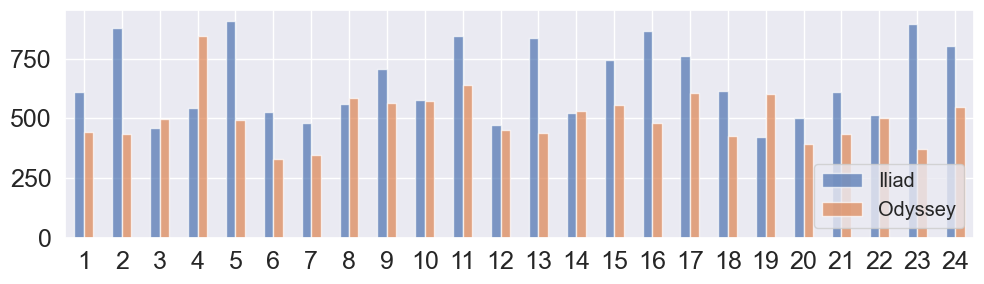

In [ ]:
# the support
ax = pd.DataFrame({'Iliad':iliad_verses_pd.groupby('bid').text.apply(lambda x: len(x)),
                   'Odyssey': odyss_verses_pd.groupby('bid').text.apply(lambda x: len(x))}).plot.bar(alpha=0.7, rot=0, figsize=(10,3))
ax.set_xlabel(''); ax.set_ylabel('', fontsize=18);
ax.tick_params(axis='both', which='major', labelsize=18)
ax.get_figure().tight_layout()
plt.legend(fontsize="large", loc='lower right')
ax.get_figure().savefig('verse_support.pdf', dpi=300, format='PDF')

In [ ]:
word_len_odyss = np.mean([len(w) for w in " ".join(odyss_verses_pd.text.to_list()).split()])
word_len_iliad = np.mean([len(w) for w in " ".join(iliad_verses_pd.text.to_list()).split()])
print(f"#chars per word \n|Odyssey: {word_len_odyss:.2f}|\n|Iliad:   {word_len_iliad:.2f}|")

#chars per word 
|Odyssey: 5.00|
|Iliad:   5.03|


In [ ]:
print(f"{odyss_verses_pd.text.str.split().apply(len).mean():.2f} words in Odyssey")
print(f"{iliad_verses_pd.text.str.split().apply(len).mean():.2f} words in Iliad")

7.20 words in Odyssey
7.13 words in Iliad


# Focusing on duplicates

In [ ]:
iliad_verses_pd.text.value_counts()[:10]

καί μιν φωνήσας ἔπεα πτερόεντα προσηύδα             15
οἳ δ᾽ ὅτε δὴ σχεδὸν ἦσαν ἐπ᾽ ἀλλήλοισιν ἰόντες      10
τὸν δ᾽ ἀπαμειβόμενος προσέφη πόδας ὠκὺς ἀχιλλεύς     9
ὣς εἰπὼν ὄτρυνε μένος καὶ θυμὸν ἑκάστου              9
ὣς οἳ μὲν τοιαῦτα πρὸς ἀλλήλους ἀγόρευον             8
ὣς ἔφαθ᾽ οἳ δ᾽ ἄρα πάντες ἀκὴν ἐγένοντο σιωπῇ        8
ὦ φίλοι ἀργείων ἡγήτορες ἠδὲ μέδοντες                8
τὸν δ᾽ ἠμείβετ᾽ ἔπειτα γερήνιος ἱππότα νέστωρ        8
ἀτρεΐδη κύδιστε ἄναξ ἀνδρῶν ἀγάμεμνον                8
διογενὲς λαερτιάδη πολυμήχαν᾽ ὀδυσσεῦ                7
Name: text, dtype: int64

In [ ]:
odyss_verses_pd.text.value_counts()[:10]

τὸν δ᾽ αὖ τηλέμαχος πεπνυμένος ἀντίον ηὔδα         30
τὸν δ᾽ ἀπαμειβόμενος προσέφη πολύμητις ὀδυσσεύς    25
ἦμος δ᾽ ἠριγένεια φάνη ῥοδοδάκτυλος ἠώς            20
τὴν δ᾽ ἀπαμειβόμενος προσέφη πολύμητις ὀδυσσεύς    19
ὣς οἱ μὲν τοιαῦτα πρὸς ἀλλήλους ἀγόρευον           15
καί μιν φωνήσας ἔπεα πτερόεντα προσηύδα            15
ὣς ἔφατ᾽ αὐτὰρ ἐγώ μιν ἀμειβόμενος προσέειπον      15
αὐτὰρ ἐπεὶ πόσιος καὶ ἐδητύος ἐξ ἔρον ἕντο         14
ἀλλ᾽ ἄγε μοι τόδε εἰπὲ καὶ ἀτρεκέως κατάλεξον      13
τὴν δ᾽ αὖ τηλέμαχος πεπνυμένος ἀντίον ηὔδα         13
Name: text, dtype: int64

* Using agglomerative clustering for near duplicates

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer

def aglo(data, data_col="text", label_col="text", threshold=1):
  vec = TfidfVectorizer()
  X = vec.fit_transform(data[data_col].values)
  Z = linkage(X.toarray(), 'ward')
  plt.figure(figsize=(8, 100))
  dendrogram(Z,
            orientation='right',
            labels=data[label_col].values,
            distance_sort='descending',
            show_leaf_counts=False,
            leaf_font_size=12.,
            show_contracted=True,
            )
  plt.show();
  return fcluster(Z, t=threshold, criterion='distance')

In [ ]:
clustering = aglo(iliad_verses_pd[iliad_verses_pd.bid==1])

In [ ]:
i1 = iliad_verses_pd[iliad_verses_pd.bid==1]
i1.insert(3, "dentro", clustering)

* Bringing tuples with near duplicates to study them

In [ ]:
for i in range(1, max(clustering)):
  cluster = i1[i1.dentro==i]
  if cluster.shape[0]>1:
    print("-".join(cluster.vid.apply(str).to_list()), end=": ")
    print("||".join(cluster.text.to_list()))

511-517-560: ὣς φάτο τὴν δ᾽ οὔ τι προσέφη νεφεληγερέτα ζεύς||τὴν δὲ μέγ᾽ ὀχθήσας προσέφη νεφεληγερέτα ζεύς||τὴν δ᾽ ἀπαμειβόμενος προσέφη νεφεληγερέτα ζεύς
84-215-364: τὸν δ᾽ ἀπαμειβόμενος προσέφη πόδας ὠκὺς ἀχιλλεύς||τὴν δ᾽ ἀπαμειβόμενος προσέφη πόδας ὠκὺς ἀχιλλεύς||τὴν δὲ βαρὺ στενάχων προσέφη πόδας ὠκὺς ἀχιλλεύς
130-285: τὸν δ᾽ ἀπαμειβόμενος προσέφη κρείων ἀγαμέμνων||τὸν δ᾽ ἀπαμειβόμενος προσέφη κρείων ἀγαμέμνων
102-355-411: ἥρως ἀτρεΐδης εὐρὺ κρείων ἀγαμέμνων||ἦ γάρ μ᾽ ἀτρεΐδης εὐρὺ κρείων ἀγαμέμνων||γνῷ δὲ καὶ ἀτρεΐδης εὐρὺ κρείων ἀγαμέμνων
196-209: ἄμφω ὁμῶς θυμῷ φιλέουσά τε κηδομένη τε||ἄμφω ὁμῶς θυμῷ φιλέουσά τε κηδομένη τε
38-452: κίλλάν τε ζαθέην τενέδοιό τε ἶφι ἀνάσσεις||κίλλαν τε ζαθέην τενέδοιό τε ἶφι ἀνάσσεις
13-372: λυσόμενός τε θύγατρα φέρων τ᾽ ἀπερείσι᾽ ἄποινα||λυσόμενός τε θύγατρα φέρων τ᾽ ἀπερείσι᾽ ἄποινα
23-377: αἰδεῖσθαί θ᾽ ἱερῆα καὶ ἀγλαὰ δέχθαι ἄποινα||αἰδεῖσθαί θ᾽ ἱερῆα καὶ ἀγλαὰ δέχθαι ἄποινα
12-371: ἀτρεΐδης ὃ γὰρ ἦλθε θοὰς ἐπὶ νῆας ἀχαιῶν||ἦλθε θοὰς ἐπὶ νῆας ἀ

* Same for Odyssey (book 2)

In [ ]:
o2 = odyss_verses_pd[odyss_verses_pd.bid==2]
o2.insert(3, "dentro", aglo(odyss_verses_pd[odyss_verses_pd.bid==2]))
for i in range(1, max(clustering)):
  cluster = o2[o2.dentro==i]
  if cluster.shape[0]>1:
    print("-".join(cluster.vid.apply(str).to_list()), end=": ")
    print("||".join(cluster.text.to_list()))

## Statistical language modelling

Perplexity (PPL) as described by [Pavlopoulos & Konstantinidou (2022)](https://link.springer.com/article/10.1007/s42803-022-00046-7), with the average number of characters per word weighing BPC ([code](https://github.com/ipavlopoulos/compauth/blob/main/analysing_iliad_and_odyssey.ipynb)).

In [ ]:
ppl_adj = lambda lm, text, f=5: np.power(2, f*lm.cross_entropy(text))

The methodology comprises the cyclic development of 24 models per poem, each build on the text of the rest 23 books. The verses of the left-out book are scored by this model.

In [ ]:
poems = {"iliad": iliad_verses_pd, "odyssey": odyss_verses_pd}
models = {"iliad":{}, "odyssey":{}}

In [ ]:
# computing the 24 Iliad and Odyssey language models
for name in poems:
  poem = poems[name]
  for i in range(1,25):
    train_data = "\n".join(poem[poem.bid!=i].text.to_list())
    model = SLM(gram="CHAR").train(train_data)
    models[name][i] = model

Measuring the PPL per verse when the model is trained on the verses of the rest of the books.

In [ ]:
ppls = {"iliad":[], "odyssey":[]}
for name in poems: # for each poem
    poem = poems[name]
    for book_id in range(1,25):
        book = poem[poem.bid==book_id] # for each book
        model = models[name][book_id] # and model trained on **all but** this book
        for t,_,_,_ in book.to_numpy():
            ppls[name].append(ppl_adj(model, t+"\n")) # compute the PPL per book verse
    poem["ppl"] = ppls[name]

* Iliad

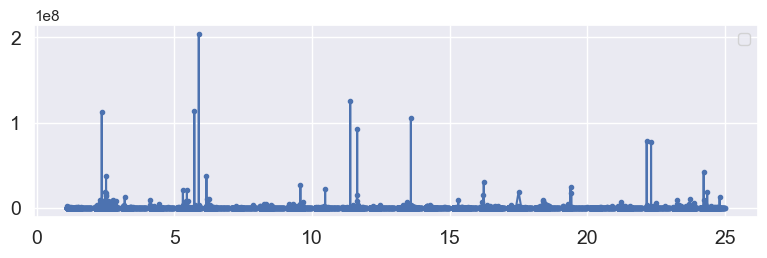

In [ ]:
sns.set(rc={'figure.figsize':(20,3)})
ax = poems["iliad"].plot(marker=".", y="ppl", x="uid", title="Iliad", figsize=(8,3));
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_figure().tight_layout()
plt.legend('')
plt.title('')
ax.set_xlabel("", fontsize=18); ax.set_ylabel("", fontsize=12);
ax.get_figure().savefig('iliad_ppl.pdf', dpi=300, format='PDF')

In [ ]:
poems["iliad"].sort_values(by="ppl", ascending=False)

text  vid  bid     uid  \
3379              ἤ κε ζὼς ἀμενηνὸς ἔα χαλκοῖο τυπῇσι  887    5   5.887   
6646            τοξότα λωβητὴρ κέρᾳ ἀγλαὲ παρθενοπῖπα  385   11  11.385   
3215             χάλκεα ὀκτάκνημα σιδηρέῳ ἄξονι ἀμφίς  723    5   5.723   
973          ὡς φρήτρη φρήτρηφιν ἀρήγῃ φῦλα δὲ φύλοις  363    2   2.363   
8168         θρῴσκωσιν κύαμοι μελανόχροες ἢ ἐρέβινθοι  589   13  13.589   
...                                               ...  ...  ...     ...   
13648  τὴν δ᾽ ἀπαμειβόμενος προσέφη νεφεληγερέτα ζεύς  182   22  22.182   
12371  τὸν δ᾽ ἀπαμειβόμενος προσέφη νεφεληγερέτα ζεύς   19   20  20.190   
2936            μῆνιν ἀλευάμενος ἑκατηβόλου ἀπόλλωνος  444    5   5.444   
296      ἄλλο δέ τοι ἐρέω σὺ δ᾽ ἐνὶ φρεσὶ βάλλεο σῇσι  297    1   1.297   
10394           μῆνιν ἀλευάμενος ἑκατηβόλου ἀπόλλωνος  711   16  16.711   

                ppl  
3379   2.044805e+08  
6646   1.256322e+08  
3215   1.137943e+08  
973    1.129918e+08  
8168   1.057690e+08  
...             ...  
13648  5.895562e+01  
12371  5.854333e+01  
2936   4.788874e+01  
296    4.664194e+01  
10394  4.596444e+01  

[15683 rows x 5 columns]

* Odyssey:

In [ ]:
# an outlier harms visualisation, working on a copy instead
ody_copy = poems["odyssey"]
ody_copy.loc[4779, 'ppl'] = 0

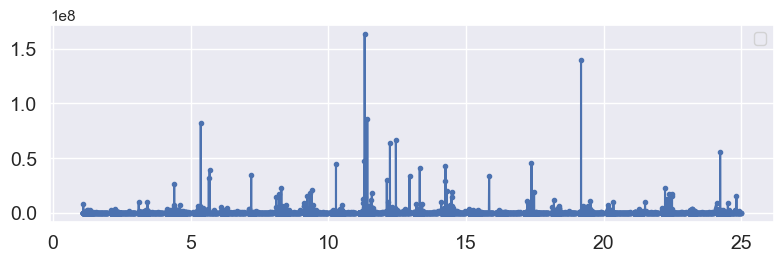

In [ ]:
ax = ody_copy.sort_values(by='uid').plot(marker=".", y="ppl", x="uid", figsize=(8,3));
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_figure().tight_layout()
plt.legend('')
plt.title('')
ax.set_xlabel("", fontsize=18); ax.set_ylabel("", fontsize=12);
ax.get_figure().savefig('odyss_ppl.pdf', dpi=300, format='PDF')

In [ ]:
ody_copy.sort_values(by="ppl", ascending=False)[:10]

text  vid  bid     uid  \
5437      ἀνθῆσαι πυκάσαι τε γένυς ἐυανθέι λάχνῃ  320   11  11.320   
9431       δωριέες τε τριχάϊκες δῖοί τε πελασγοί  177   19  19.177   
5532          ἢ γάμῳ ἢ ἐράνῳ ἢ εἰλαπίνῃ τεθαλυίῃ  415   11  11.415   
2589        ὡς δ᾽ ἄνεμος ζαὴς ἠΐων θημῶνα τινάξῃ  368    5   5.368   
6210        αὖτις ἀριζήλως εἰρημένα μυθολογεύειν  453   12  12.453   
5995   πᾶσ᾽ ἀναμορμύρεσκε κυκωμένη ὑψόσε δ᾽ ἄχνη  238   12  12.238   
11787    κνημῖδας ῥαπτὰς δέδετο γραπτῦς ἀλεείνων  229   24  24.229   
5418        τοὺς ἄμφω ζωοὺς κατέχει φυσίζοος αἶα  301   11  11.301   
8597         πτωχοὶ ἀνιηροί δαιτῶν ἀπολυμαντῆρες  377   17  17.377   
4823       πρῶτον ὑπηνήτῃ τοῦ περ χαριεστάτη ἥβη  279   10  10.279   

                ppl  
5437   1.637553e+08  
9431   1.398262e+08  
5532   8.602733e+07  
2589   8.178060e+07  
6210   6.703228e+07  
5995   6.376559e+07  
11787  5.598877e+07  
5418   4.696230e+07  
8597   4.532968e+07  
4823   4.470844e+07

Studying high-PPL (peaks) verses:

In [ ]:
for name in poems:
  poem = poems[name]
  print(f"{name.upper()} {poem[poem.ppl==poem.ppl.max()][['text','uid']]}")

ILIAD                                      text    uid
3379  ἤ κε ζὼς ἀμενηνὸς ἔα χαλκοῖο τυπῇσι  5.887
ODYSSEY                                         text    uid
5437  ἀνθῆσαι πυκάσαι τε γένυς ἐυανθέι λάχνῃ  11.32


In [ ]:
# number of verses
poems['iliad'].shape[0] + poems['odyssey'].shape[0]

27790

# Correlation between PPL and IVF

* Studying the relationship between the PPL and the Inverse Document Frequency (IVF) at the verse level.
* Computing the min/max/avg per verse.
* Change the vectorizer to alter between the character and the word level.

In [ ]:
# get the min, max, mean document frequencies for a text's words
def get_df(txt, vec, df):
    words = vec.build_tokenizer()(txt)
    df_scores = [df[w] for w in words]
    idf_pd = pd.DataFrame({'word':words, 'IDF':df_scores})
    return idf_pd

* Iliad

In [ ]:
poem = poems["iliad"]
# compute word IDF then map verse words to their IDFs
vec_i = TfidfVectorizer().fit(poem.text.values);
df_i = dict(zip(vec_i.get_feature_names_out(), vec_i.idf_))
# testing
print(vec_i.build_tokenizer()(poem.text.iloc[0]))
first_verse_idfs = get_df(poem.text.iloc[0], vec_i, df_i)
print(first_verse_idfs.IDF.agg(["min", "max", "mean"]))
first_verse_idfs

['μῆνιν', 'ἄειδε', 'θεὰ', 'πηληϊάδεω', 'ἀχιλῆος']
min     6.383730
max     9.274102
mean    7.954383
Name: IDF, dtype: float64


word       IDF
0      μῆνιν  8.357811
1      ἄειδε  9.274102
2        θεὰ  6.383730
3  πηληϊάδεω  8.463172
4    ἀχιλῆος  7.293101

In [ ]:
# setting up the dataframe (ppl, min_df, max_df, avg_df)
ablation_i = pd.DataFrame(list(poem.text.apply(lambda x: get_df(x, vec_i, df_i).IDF.agg(["min", "max", "mean"]).values)),
                          columns=("IDF-min", "IDF-max", "IDF-avg"))
ablation_i.insert(0, "PPL", poem.ppl)
# drawing
sns.set_theme(style="white")
mask = np.zeros_like(ablation_i.corr(), dtype=bool) # Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generating a custom diverging colormap

              PPL   IDF-min   IDF-max   IDF-avg
PPL      1.000000  0.045785  0.668614  0.415099
IDF-min  0.045785  1.000000  0.058268  0.600922
IDF-max  0.668614  0.058268  1.000000  0.419328
IDF-avg  0.415099  0.600922  0.419328  1.000000


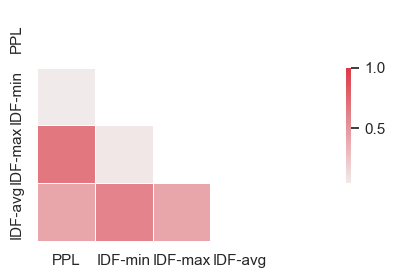

In [ ]:
print(ablation_i.corr('spearman'))
sns.heatmap(ablation_i.corr('spearman'), mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

* Same for Pearson:

              PPL   IDF-min   IDF-max   IDF-avg
PPL      1.000000  0.048272  0.040645  0.090277
IDF-min  0.048272  1.000000  0.067132  0.672106
IDF-max  0.040645  0.067132  1.000000  0.453010
IDF-avg  0.090277  0.672106  0.453010  1.000000


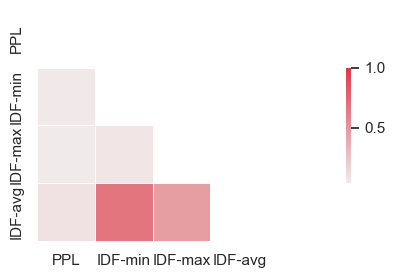

In [ ]:
print(ablation_i.corr())
sns.heatmap(ablation_i.corr(), mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

* When applying a log, the linear relationship appears (smoothed the outliers?)

In [ ]:
print(ablation_i.apply(np.log).corr())

              PPL   IDF-min   IDF-max   IDF-avg
PPL      1.000000  0.056629  0.581083  0.434275
IDF-min  0.056629  1.000000  0.054968  0.625125
IDF-max  0.581083  0.054968  1.000000  0.466724
IDF-avg  0.434275  0.625125  0.466724  1.000000


In [ ]:
poems["iliad"]["idf"] = ablation_i["IDF-min"]
poems["iliad"]["idf_avg"] = ablation_i["IDF-avg"]

* Odyssey:

In [ ]:
poem = poems["odyssey"]
vec_o = TfidfVectorizer().fit(poem.text.values);
df_o = dict(zip(vec_o.get_feature_names_out(), vec_o.idf_))
# testing
print(vec_o.build_tokenizer()(poem.text.iloc[0]))
first_verse_idfs = get_df(poem.text.iloc[0], vec_o, df_o)
print(first_verse_idfs.IDF.agg(["min", "max", "mean"]))
first_verse_idfs

['ἄνδρα', 'μοι', 'ἔννεπε', 'μοῦσα', 'πολύτροπον', 'ὃς', 'μάλα', 'πολλὰ']
min     4.347182
max     9.708474
mean    7.101521
Name: IDF, dtype: float64


word       IDF
0       ἄνδρα  6.905114
1         μοι  4.347182
2      ἔννεπε  9.708474
3       μοῦσα  9.303009
4  πολύτροπον  9.708474
5          ὃς  5.924285
6        μάλα  5.358197
7       πολλὰ  5.557435

In [ ]:
ablation_o = pd.DataFrame(list(poem.text.apply(lambda x: get_df(x, vec_o, df_o).IDF.agg(["min", "max", "mean"]).values)),
                          columns=("min", "max", "avg"))
ablation_o.insert(0, "ppl", poem.ppl)
# drawing
mask = np.zeros_like(ablation_o.corr(), dtype=bool) # Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generating a custom diverging colormap
poems["odyssey"]["idf"] = ablation_o["min"]
poems["odyssey"]["idf_avg"] = ablation_o["avg"]

          ppl       min       max       avg
ppl  1.000000  0.013225  0.702360  0.435841
min  0.013225  1.000000  0.025867  0.548828
max  0.702360  0.025867  1.000000  0.437890
avg  0.435841  0.548828  0.437890  1.000000


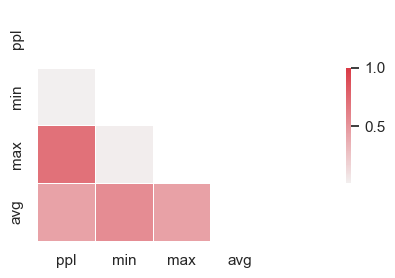

In [ ]:
print(ablation_o.corr('spearman'))
sns.heatmap(ablation_o.corr('spearman'), mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

* Same for Pearson:

          ppl       min       max       avg
ppl  1.000000  0.048272  0.053121  0.114780
min  0.048272  1.000000  0.021191  0.639473
max  0.053121  0.021191  1.000000  0.471411
avg  0.114780  0.639473  0.471411  1.000000


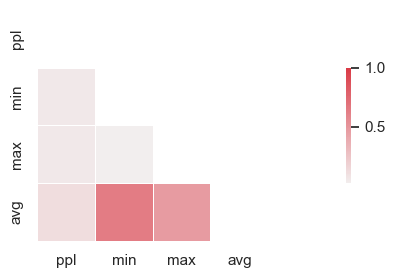

In [ ]:
print(ablation_o.corr())
sns.heatmap(ablation_o.corr(), mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Combining the PPLs from the Iliadic and the Odyssey model

In [ ]:
train_data_o = "\n".join(poems["odyssey"].text.explode().to_list())
odyssey_model = SLM(gram="CHAR").train(train_data_o)
train_data_i = "\n".join(poems["iliad"].text.explode().to_list())
iliad_model = SLM(gram="CHAR").train(train_data_i)

In [ ]:
cross_score = lambda t, m1, m2: ppl_adj(m1, t+"\n")-ppl_adj(m2, t+"\n")
csi = poems["iliad"].text.apply(lambda t: cross_score(t, odyssey_model, iliad_model)) # o-i (greater is better)
poems["iliad"]["cross_score"] =csi

In [ ]:
cso = poems["odyssey"].text.apply(lambda t: cross_score(t, iliad_model, odyssey_model)) # o-i
poems["odyssey"]["cross_score"] = cso

* Computing the PPL of an Iliadic LM on Odyssey verses, and vise versa

In [ ]:
poems["iliad"]['odyssey_ppl'] = poems["iliad"].text.apply(lambda t: ppl_adj(odyssey_model, t+"\n"))
poems["odyssey"]['iliad_ppl'] = poems["odyssey"].text.apply(lambda t: ppl_adj(iliad_model, t+"\n"))

#### Interpreting the cross score
* lower cross-score means closer to the poem's spirit, higher means closer to the other
* this is also shown by comparing PPL (the official) with that of 'the other' poem (trained on all the verses)

In [ ]:
poems["odyssey"].head()

text  vid  bid  uid  \
0   ἄνδρα μοι ἔννεπε μοῦσα πολύτροπον ὃς μάλα πολλὰ    1    1  1.1   
1      πλάγχθη ἐπεὶ τροίης ἱερὸν πτολίεθρον ἔπερσεν    2    1  1.2   
2       πολλῶν δ᾽ ἀνθρώπων ἴδεν ἄστεα καὶ νόον ἔγνω    3    1  1.3   
3  πολλὰ δ᾽ ὅ γ᾽ ἐν πόντῳ πάθεν ἄλγεα ὃν κατὰ θυμόν    4    1  1.4   
4          ἀρνύμενος ἥν τε ψυχὴν καὶ νόστον ἑταίρων    5    1  1.5   

            ppl       idf   idf_avg   cross_score     iliad_ppl  
0  84939.053257  4.347182  7.101521  13182.070617  13487.649216  
1  43732.722232  4.649049  8.047691   2433.673600   4482.511761  
2   8874.790142  2.743394  7.079644   4218.027442   6626.647481  
3   1302.901730  3.983257  6.363259   7530.757202   8434.938648  
4   2546.142932  2.743394  6.658610   1307.190261   2212.977968

In [ ]:
iliad_verses_pd.sort_values(by='cross_score').head(10)

text  vid  bid     uid  \
11915                                      τερπόμενοι  604   18  18.604   
3891     ἀλλ᾽ εἰς οἶκον ἰοῦσα τὰ σ᾽ αὐτῆς ἔργα κόμιζε  490    6   6.490   
484       νῆα μὲν οἵ γε μέλαιναν ἐπ᾽ ἠπείροιο ἔρυσσαν  485    1   1.485   
8400          ὣς ἄρα οἱ εἰπόντι ἐπέπτατο δεξιὸς ὄρνις  821   13  13.821   
4578           ἄξεις ἐν νήεσσι πάρος τοι δαίμονα δώσω  169    8   8.169   
6258        ἔς ῥ᾽ ἀσαμίνθους βάντες ἐϋξέστας λούσαντο  576   10  10.576   
12361            καὶ πηγὰς ποταμῶν καὶ πίσεα ποιήεντα    9   20  20.900   
7330     οὐδ᾽ ἐτέλεσσε φέρων δόμεναι τεκέεσσιν ἑοῖσιν  222   12  12.222   
4644              πίνοντες κρητῆρας ἐπιστεφέας οἴνοιο  236    8   8.236   
4246   τὸν δέρον ἀμφί θ᾽ ἕπον καί μιν διέχευαν ἅπαντα  316    7   7.316   

                ppl       idf   idf_avg   cross_score    odyssey_ppl  
11915  2.931614e+05  9.274102  9.274102 -28877.615239  239599.843733  
3891   6.180436e+04  4.455839  7.116549  -5059.860250    1869.064276  
484    8.936078e+04  3.823064  6.848211  -4717.818664    1033.617653  
8400   2.489763e+04  4.133902  7.351746  -3963.978939    2064.380172  
4578   9.329997e+03  3.999821  7.176612  -3790.066440    2528.415939  
6258   1.621521e+06  9.050958  9.645362  -3640.782234     802.317693  
12361  2.721494e+06  2.854107  7.413100  -3544.647546    3062.607752  
7330   8.822616e+03  4.936811  8.230379  -2998.981226    1652.773380  
4644   2.373729e+04  8.868637  9.417943  -2979.106354    2584.651642  
4246   2.245267e+05  4.410421  7.551741  -2929.225487    2399.207019

In [ ]:
odyss_verses_pd.sort_values(by='cross_score').head(10)

text  vid  bid     uid  \
12046            βῆ δὲ κατ᾽ οὐλύμποιο καρήνων ἀΐξασα  488   24  24.488   
10810     ἵππουριν δεινὸν δὲ λόφος καθύπερθεν ἔνευεν  124   22  22.124   
5387    τὴν ἔχεν ἀμφιτρύωνος υἱὸς μένος αἰὲν ἀτειρής  270   11  11.270   
11635       μίγδα δὲ πατρόκλοιο μενοιτιάδαο θανόντος   77   24  24.770   
11618     μοῦσαι δ᾽ ἐννέα πᾶσαι ἀμειβόμεναι ὀπὶ καλῇ   60   24  24.600   
10702     ἀντικρὺ δ᾽ ἁπαλοῖο δι᾽ αὐχένος ἤλυθ᾽ ἀκωκή   16   22  22.160   
6855         ὃς τότ᾽ ἐνὶ κρήτεσσι θεὸς ὣς τίετο δήμῳ  205   14  14.205   
1393         μολπῆς ἐξάρχοντος ἐδίνευον κατὰ μέσσους   19    4   4.190   
8224   εἵλετο δ᾽ ἄλκιμον ἔγχος ὅ οἱ παλάμηφιν ἀρήρει    4   17  17.400   
9100   ἀλλὰ τόδ᾽ αἰνὸν ἄχος κραδίην καὶ θυμὸν ἱκάνει  274   18  18.274   

                ppl       idf   idf_avg  cross_score    iliad_ppl  
12046  2.258864e+04  3.369880  7.412214 -4789.328629   989.781430  
10810  1.316498e+05  3.369880  8.117238 -3075.102680  1471.016567  
5387   5.367853e+05  5.404409  7.623728 -2706.839095  5450.347594  
11635  2.745275e+06  3.369880  8.302126 -2435.499486  1447.840178  
11618  1.284590e+04  7.629033  8.691009 -2398.150137  2595.804433  
10702  1.201651e+05  7.836672  9.004612 -2354.874425  1189.266010  
6855   1.088427e+05  4.121226  6.624600 -2333.333137  1879.819046  
1393   2.975372e+06  4.892233  8.606597 -2244.324105  1674.299362  
8224   1.547084e+05  3.952732  7.797515 -2151.866666  1104.796110  
9100   5.766783e+03  2.743394  6.891329 -1953.579796   857.328033

In [ ]:
print(f'{odyss_verses_pd[odyss_verses_pd.cross_score<0].shape[0]/odyss_verses_pd.shape[0]:.2f}')
print(f'{iliad_verses_pd[iliad_verses_pd.cross_score<0].shape[0]/iliad_verses_pd.shape[0]:.2f}')

0.02
0.03


In [ ]:
#@title Download the recognised name entities per poem
#@markdown You will be asked to enter two IDs (same as before)
from ast import literal_eval
iliad_nered = input('Enter the ID of the NERed Iliad: ')
odyss_nered = input('Enter the ID of the NERed Odyssey: ')
!gdown "$iliad_nered"
!gdown "$odyss_nered"

In [ ]:
import re
def extract_names(text, rec_type='PER'):
  assert rec_type in {'PER', 'LOC'}
  recognitions = text.split(',')
  pattern = r'"[^"]*"'
  results = []
  for text in recognitions:
    if rec_type in text:
      matches = re.findall(pattern, text)
      if len(matches)>0:
        results.append(matches[0])
  return results

In [ ]:
persons_iliad = pd.read_csv('iliad_ner.csv')['ne'].apply(lambda x: extract_names(x, 'PER'))
persons_odyss = pd.read_csv('odyss_ner.csv')['ne'].apply(lambda x: extract_names(x, 'PER'))

In [ ]:
locations_iliad = pd.read_csv('iliad_ner.csv')['ne'].apply(lambda x: extract_names(x, 'LOC'))
locations_odyss = pd.read_csv('odyss_ner.csv')['ne'].apply(lambda x: extract_names(x, 'LOC'))

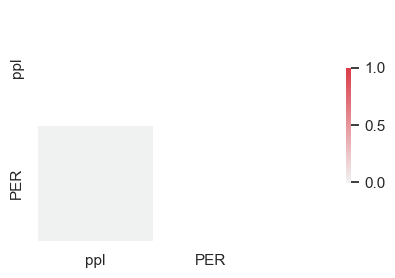

In [ ]:
# assessing the correlation between DF and PPL for Odyssey
cor = pd.DataFrame({'ppl': poems["iliad"]["ppl"], 'PER': persons_iliad.apply(len)}).corr()
mask = np.zeros_like(cor, dtype=bool) # Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generating a custom diverging colormap
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

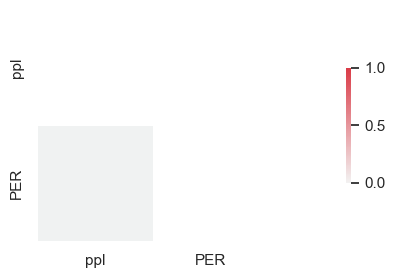

In [ ]:
# assessing the correlation between DF and PPL for Odyssey
cor = pd.DataFrame({'ppl': poems["odyssey"]["ppl"], 'PER': persons_odyss.apply(len)}).corr()
mask = np.zeros_like(cor, dtype=bool) # Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generating a custom diverging colormap
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Correlation study

In [ ]:
# computing the new 24 Iliad and Odyssey language models
models = {"iliad":{}, "odyssey":{}}
for name in poems:
  poem = poems[name]
  for i in range(1,25):
    train_data = "\n".join(poem[poem.bid==i].text.to_list())
    model = SLM(gram="CHAR").train(train_data)
    models[name][i] = model

In [ ]:
ppls = {"iliad":[], "odyssey":[]}
for name in poems: # for each poem
  poem = poems[name]
  for book_id in range(1,25):
    model = models[name][book_id] # one model (trained) per book
    ppls[name].append([ppl_adj(model, t+"\n") for t in poem.text.to_list()]) # PPL per verse per book-model

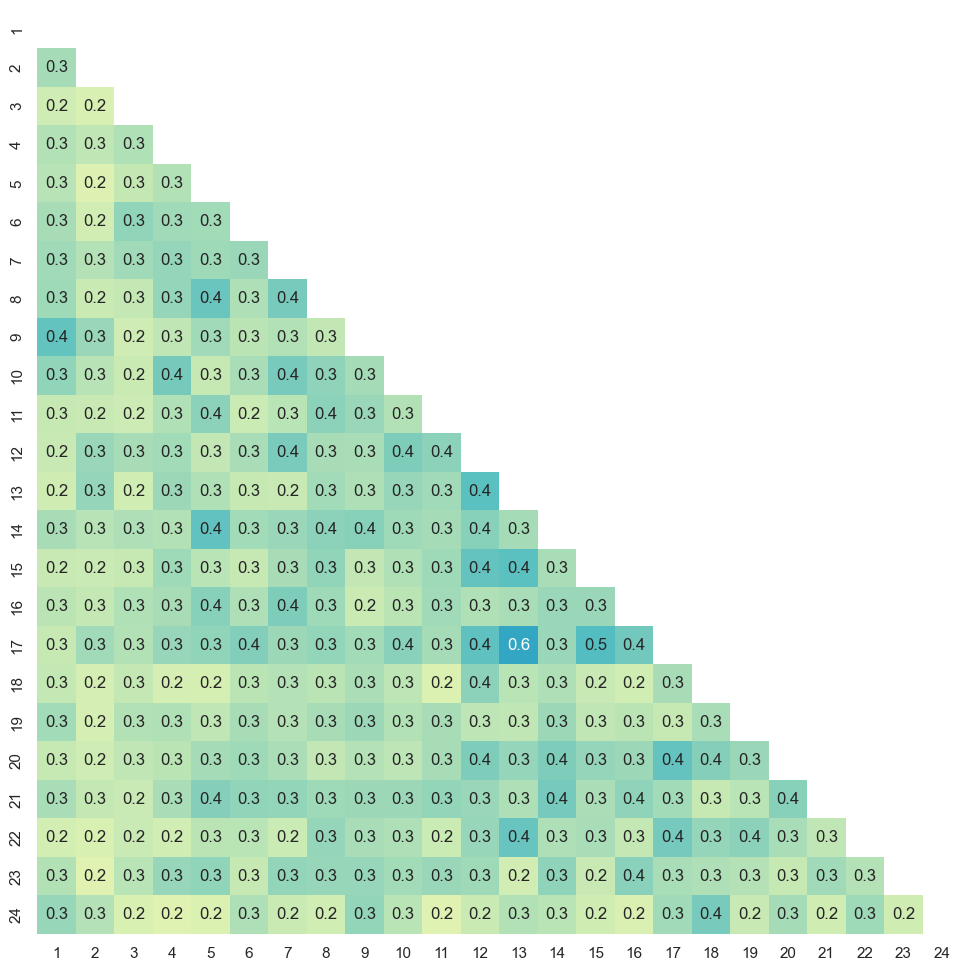

In [ ]:
# ILIAD
corr = pd.DataFrame(dict(zip(list(range(1,25)), ppls["iliad"]))).corr()
sns.set(rc={'figure.figsize':(12,12)})
mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0,
              vmax=1, annot=True, fmt=".1f", cmap="YlGnBu", mask=mask, square=True, cbar=False);

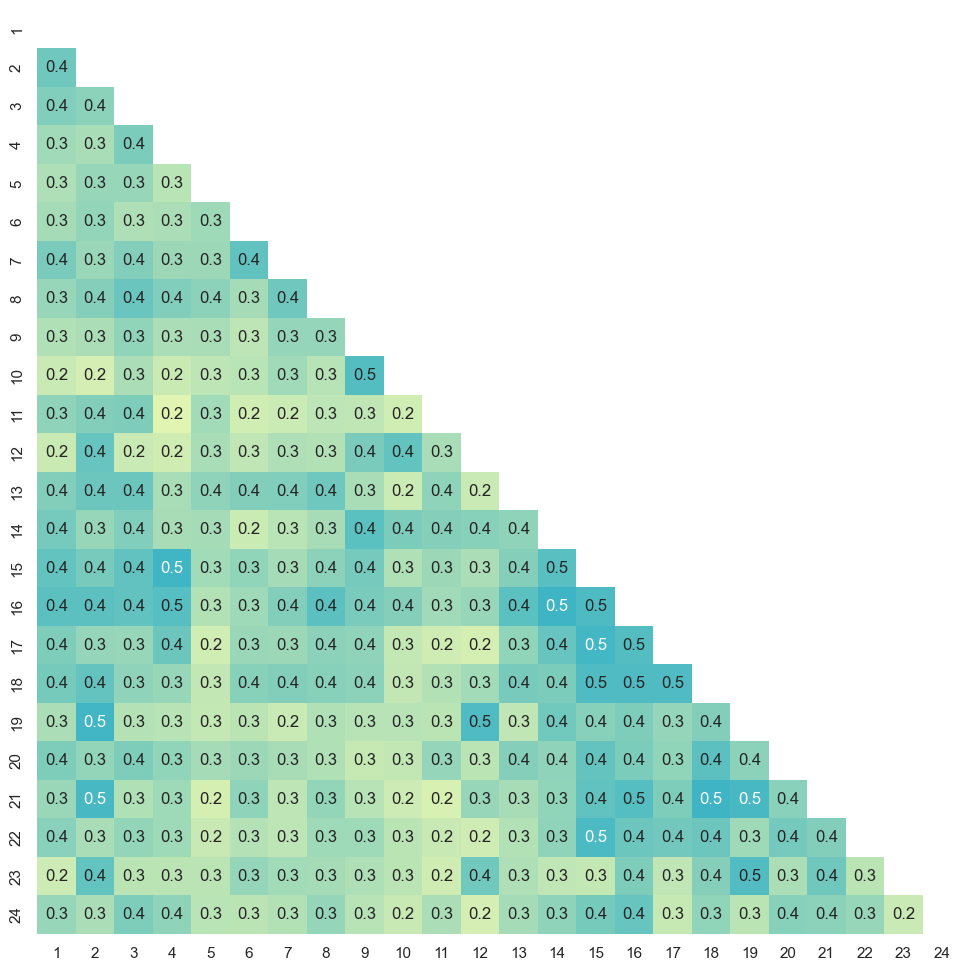

In [ ]:
# Odyssey
corr = pd.DataFrame(dict(zip(list(range(1,25)), ppls["odyssey"]))).corr()
sns.set(rc={'figure.figsize':(12,12)})
mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0,
              vmax=1, annot=True, fmt=".1f", cmap="YlGnBu", mask=mask, square=True, cbar=False);

### Investigating repeated verses

In [ ]:
iliad_duplct = iliad_verses_pd[iliad_verses_pd.duplicated(subset="text")]
iliad_duplct_not = iliad_verses_pd[~iliad_verses_pd.duplicated(subset="text")]
odyss_duplct = odyss_verses_pd[odyss_verses_pd.duplicated(subset="text")]
odyss_duplct_not = odyss_verses_pd[~odyss_verses_pd.duplicated(subset="text")]
print(f"{iliad_duplct.shape[0]} verses are duplicated in Iliad and {odyss_duplct.shape[0]} in Odyssey.")
print(f"That is {100*iliad_duplct.shape[0]/iliad_verses_pd.shape[0]:.2f}% in Iliad and {100*odyss_duplct.shape[0]/odyss_verses_pd.shape[0]:.2f}% in Odyssey.")
#1008 verses are duplicated in Iliad and 1035 in Odyssey.
#That is 6.43% in Iliad and 8.55% in Odyssey.

1183 verses are duplicated in Iliad and 1179 in Odyssey.
That is 7.54% in Iliad and 9.74% in Odyssey.


Building models on non-repeated verses, from the first part of each poem. Then using them to score text from repeated and non-repeated verses. The first yields lower PPL, despite the fact that the models were trained on non-repeated verses.

In [ ]:
iliad_cnt_lm = SLM(gram="CHAR").train("\n".join(iliad_duplct_not.iloc[:6000].text.values))
odyss_cnt_lm = SLM(gram="CHAR").train("\n".join(odyss_duplct_not.iloc[:6000].text.values))

In [ ]:
sample_size, repetitions = 30, 300
# sample repeated (RV) and not repeated (NRV) verses and compare their mean PPL
for name, rv, nrv, model in (("Iliad", iliad_duplct, iliad_duplct_not.iloc[6000:], iliad_cnt_lm), ("Odyssey", odyss_duplct, odyss_duplct_not.iloc[6000:], odyss_cnt_lm)):
  bootstrap = []
  for i in range(300):
    bootstrap.append(rv.sample(30).text.apply(model.ppl).mean() > nrv.sample(30).text.apply(model.ppl).mean())
  print(f"[{name}] P value: {np.mean(bootstrap)}")

[Iliad] P value: 0.0
[Odyssey] P value: 0.0


Visualising the position of the repeated verses


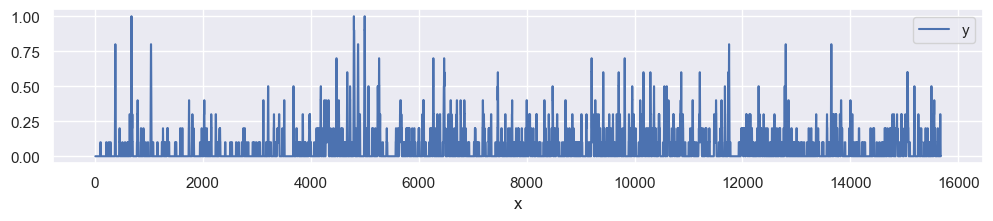

In [ ]:
# iliad
duplicates = set(iliad_duplct.index.to_list())
x = range(iliad_verses_pd.shape[0])
y = [1 if i in duplicates else 0 for i in x]
pd.DataFrame({"x":x, "y":y}).rolling(10).mean().plot(x="x", figsize=(12,2));

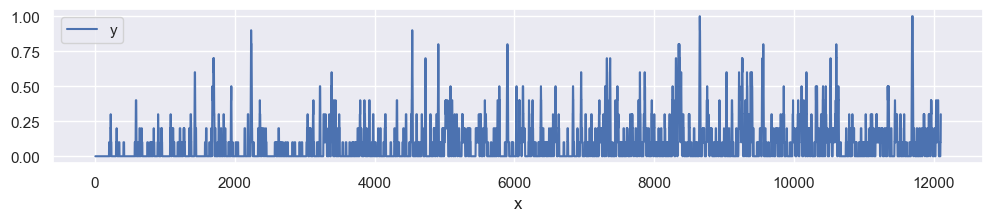

In [ ]:
# odyssey
duplicates = set(odyss_duplct.index.to_list())
x = range(odyss_verses_pd.shape[0])
y = [1 if i in duplicates else 0 for i in x]
pd.DataFrame({"x":x, "y":y}).rolling(10).mean().plot(x="x", figsize=(12,2));

Exploring the most frequent ones

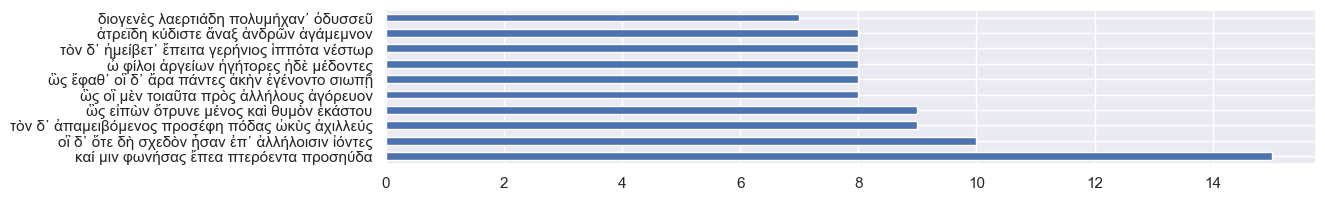

In [ ]:
iliad_verses_pd.text.value_counts(ascending=False)[:10].plot.barh(figsize=(12,2));

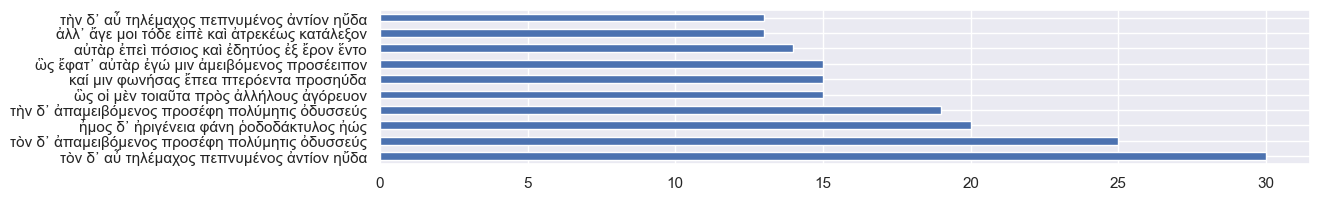

In [ ]:
odyss_verses_pd.text.value_counts(ascending=False)[:10].plot.barh(figsize=(12,2));

## Focusing on the Catalogue of Ships

In [ ]:
iliad_verses_pd[iliad_verses_pd.bid==2]

text  vid  bid    uid  \
611      ἄλλοι μέν ῥα θεοί τε καὶ ἀνέρες ἱπποκορυσταὶ    1    2  2.100   
612      εὗδον παννύχιοι δία δ᾽ οὐκ ἔχε νήδυμος ὕπνος    2    2  2.200   
613          ἀλλ᾽ ὅ γε μερμήριζε κατὰ φρένα ὡς ἀχιλῆα    3    2  2.300   
614          τιμήσῃ ὀλέσῃ δὲ πολέας ἐπὶ νηυσὶν ἀχαιῶν    4    2  2.400   
615         ἥδε δέ οἱ κατὰ θυμὸν ἀρίστη φαίνετο βουλή    5    2  2.500   
...                                               ...  ...  ...    ...   
1483  νήπιος οὐδέ τί οἱ τό γ᾽ ἐπήρκεσε λυγρὸν ὄλεθρον  873    2  2.873   
1484           ἀλλ᾽ ἐδάμη ὑπὸ χερσὶ ποδώκεος αἰακίδαο  874    2  2.874   
1485     ἐν ποταμῷ χρυσὸν δ᾽ ἀχιλεὺς ἐκόμισσε δαΐφρων  875    2  2.875   
1486      σαρπηδὼν δ᾽ ἦρχεν λυκίων καὶ γλαῦκος ἀμύμων  876    2  2.876   
1487           τηλόθεν ἐκ λυκίης ξάνθου ἄπο δινήεντος  877    2  2.877   

              ppl       idf   idf_avg   cross_score   odyssey_ppl  
611   1140.240257  2.854107  6.078516  3.177787e+04  3.258942e+04  
612   4769.961845  5.352129  7.741270  1.890625e+04  2.027654e+04  
613   9380.597342  4.455839  6.217049  1.252234e+04  1.412880e+04  
614   4919.230604  3.076132  6.655258  1.288694e+04  1.358294e+04  
615    745.287518  4.115047  6.608635 -1.358635e+02  5.005803e+02  
...           ...       ...       ...           ...           ...  
1483  2904.506116  4.457861  7.137772  5.704261e+02  1.119442e+03  
1484  3748.123649  4.455839  7.057518  7.029380e+03  7.649829e+03  
1485  6751.494177  3.999821  7.792673  8.724182e+03  9.946254e+03  
1486  1976.830442  2.854107  7.334643  1.311329e+07  1.311434e+07  
1487  5658.018374  4.849255  7.777785  5.725030e+05  5.734619e+05  

[877 rows x 9 columns]

## PPL-IVF ranking

In [ ]:
ppldf = iliad_verses_pd.ppl/iliad_verses_pd.idf
iliad_verses_pd.loc[ppldf.sort_values(ascending=False).index]

text  vid  bid     uid  \
3379              ἤ κε ζὼς ἀμενηνὸς ἔα χαλκοῖο τυπῇσι  887    5   5.887   
973          ὡς φρήτρη φρήτρηφιν ἀρήγῃ φῦλα δὲ φύλοις  363    2   2.363   
6899           οἴνῳ πραμνείῳ ἐπὶ δ᾽ αἴγειον κνῆ τυρὸν  638   11  11.638   
13618             ἢ χιόνι ψυχρῇ ἢ ἐξ ὕδατος κρυστάλλῳ  152   22  22.152   
3215             χάλκεα ὀκτάκνημα σιδηρέῳ ἄξονι ἀμφίς  723    5   5.723   
...                                               ...  ...  ...     ...   
4881   τὴν δ᾽ ἀπαμειβόμενος προσέφη νεφεληγερέτα ζεύς  477    8   8.477   
14942  τὴν δ᾽ ἀπαμειβόμενος προσέφη νεφεληγερέτα ζεύς   64   24  24.640   
13648  τὴν δ᾽ ἀπαμειβόμενος προσέφη νεφεληγερέτα ζεύς  182   22  22.182   
2936            μῆνιν ἀλευάμενος ἑκατηβόλου ἀπόλλωνος  444    5   5.444   
10394           μῆνιν ἀλευάμενος ἑκατηβόλου ἀπόλλωνος  711   16  16.711   

                ppl       idf   idf_avg   cross_score   odyssey_ppl  
3379   2.044805e+08  5.484247  8.844867  4.433405e+07  4.434144e+07  
973    1.129918e+08  3.076132  8.019241  8.058138e+07  8.058313e+07  
6899   9.237534e+07  4.569086  8.914840  5.933753e+05  5.955917e+05  
13618  7.909612e+07  5.604151  8.874907  1.156383e+08  1.156399e+08  
3215   1.137943e+08  8.868637  9.608897  3.255537e+08  3.255544e+08  
...             ...       ...       ...           ...           ...  
4881   6.027522e+01  5.777594  6.594795 -5.394205e+00  5.320403e+01  
14942  5.904083e+01  5.777594  6.594795 -5.394205e+00  5.320403e+01  
13648  5.895562e+01  5.777594  6.594795 -5.394205e+00  5.320403e+01  
2936   4.788874e+01  8.095447  8.694580  5.349619e+03  5.389039e+03  
10394  4.596444e+01  8.095447  8.694580  5.349619e+03  5.389039e+03  

[15683 rows x 9 columns]

In [ ]:
odyss_ppldf = odyss_verses_pd.ppl/odyss_verses_pd.idf
odyss_verses_pd.loc[odyss_ppldf.sort_values(ascending=False).index]

text  vid  bid     uid  \
5437    ἀνθῆσαι πυκάσαι τε γένυς ἐυανθέι λάχνῃ  320   11  11.320   
9431     δωριέες τε τριχάϊκες δῖοί τε πελασγοί  177   19  19.177   
2589      ὡς δ᾽ ἄνεμος ζαὴς ἠΐων θημῶνα τινάξῃ  368    5   5.368   
6905   νηῶν πημάνθη  ἀλλ᾽ ἀσκηθέες καὶ ἄνουσοι  255   14  14.255   
2290        ἡμερὶς ἡβώωσα τεθήλει δὲ σταφυλῇσι   69    5   5.690   
...                                        ...  ...  ...     ...   
7136     διογενὲς λαερτιάδη πολυμήχαν᾽ ὀδυσσεῦ  486   14  14.486   
12100    διογενὲς λαερτιάδη πολυμήχαν᾽ ὀδυσσεῦ  542   24  24.542   
7906     διογενὲς λαερτιάδη πολυμήχαν᾽ ὀδυσσεῦ  166   16  16.166   
10850    διογενὲς λαερτιάδη πολυμήχαν᾽ ὀδυσσεῦ  164   22  22.164   
4779      οἴνῳ πραμνείῳ ἐκύκα ἀνέμισγε δὲ σίτῳ  235   10  10.235   

                ppl       idf   idf_avg   cross_score     iliad_ppl  
5437   1.637553e+08  3.602566  8.690823  1.724783e+07  1.724931e+07  
9431   1.398262e+08  3.602566  7.673172  7.283161e+05  7.305462e+05  
2589   8.178060e+07  4.950583  8.563790  2.956538e+06  2.957536e+06  
6905   4.312254e+07  2.743394  7.301360  6.664335e+06  6.666650e+06  
2290   3.951275e+07  3.369880  8.440756  9.461226e+06  9.463340e+06  
...             ...       ...       ...           ...           ...  
7136   5.889213e+01  7.223568  7.559936  5.310647e+01  1.105849e+02  
12100  5.875802e+01  7.223568  7.559936  5.310647e+01  1.105849e+02  
7906   5.801232e+01  7.223568  7.559936  5.310647e+01  1.105849e+02  
10850  5.720894e+01  7.223568  7.559936  5.310647e+01  1.105849e+02  
4779   0.000000e+00  3.369880  8.184815  1.235229e+07  1.235402e+07  

[12107 rows x 9 columns]

In [ ]:
odyss_verses_pd.to_excel('holm_odyssey.xlsx')
iliad_verses_pd.to_excel('holm_iliad.xlsx')

## Exploring [Quintus](https://www.perseus.tufts.edu/hopper/text?doc=Perseus%3Atext%3A2008.01.0490) and [Augusta](https://en.wikipedia.org/wiki/Aelia_Eudocia)...